<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_13_class_weights_and_log_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scikit-Learn Pipelines

To achieve maximum flexibility in your pipeline setup, especially for swapping in different resampling methods or adding new features, leveraging scikit-learn pipelines is a great approach. Scikit-learn pipelines allow you to seamlessly integrate various preprocessing steps, feature engineering, resampling methods, and model training in a streamlined manner. Here’s a structured way to set this up:

1. **Use Scikit-Learn Pipelines for Preprocessing and Feature Engineering**: Define pipelines for common preprocessing tasks and feature engineering. These pipelines can be easily modified to include new steps as needed.

2. **Create Configurable Resampling Pipelines**: Set up your pipelines to allow easy swapping of different resampling techniques using scikit-learn's `ColumnTransformer` and `Pipeline`.

3. **Modular Functions for Flexibility**: Write modular functions to create and configure pipelines, making it easy to switch out different components.

4. **Parameterize the Pipeline**: Use function parameters to pass different resampling methods or feature engineering steps to your pipeline functions.

### Advantages of This Approach

1. **Flexibility**: Easily switch between different resampling methods, feature selection techniques, or models by simply changing the function parameters.
2. **Modularity**: The code is organized into modular functions, making it easier to maintain and extend.
3. **Readability**: Using scikit-learn pipelines keeps the workflow clear and concise, improving code readability.
4. **Reusability**: The same pipeline structure can be reused for different datasets or experiments with minimal changes.

By parameterizing the pipeline creation functions and leveraging scikit-learn’s pipeline capabilities, you can create a robust, flexible, and reusable framework for machine learning experiments.

### Experiment Description

**Objective:**
The primary objective of this experiment is to evaluate the impact of adding class weights and using log loss on the performance of various machine learning models in identifying loan defaults. The key metrics for evaluation are recall for class 1 (loan defaults), balanced F1 score, and F1-macro score. These metrics are prioritized due to the importance of accurately identifying loan defaults.

**Dataset:**
The dataset used for this experiment is the "Default of Credit Card Clients" dataset from the UCI Machine Learning Repository. The dataset contains information about credit card clients and whether they defaulted on their payments.

**Models Evaluated:**
Five different machine learning models are evaluated:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine (SVM)
4. K-Nearest Neighbors (KNN)
5. XGBoost

**Two Scenarios:**
1. **Without Class Weights and Log Loss:**
   - Models are trained without using class weights or log loss.
   - Performance metrics are calculated using default settings.

2. **With Class Weights and Log Loss:**
   - Models are adjusted to prioritize class 1 (loan defaults) by using class weights and log loss where applicable.
   - For models that support class weights (Logistic Regression, Random Forest, SVM), `class_weight='balanced'` is used.
   - For XGBoost, `scale_pos_weight` is adjusted.
   - Decision thresholds are adjusted to prioritize recall for models that do not support class weights (e.g., KNN).

**Evaluation Metrics:**
1. **Recall for Class 1**: Measures the ability of the model to correctly identify loan defaults.
2. **Balanced F1 Score**: Evaluates the balance between precision and recall for class 1.
3. **F1-Macro Score**: Averages the F1 scores for both classes, providing a measure of overall model performance.

**Results Comparison:**
The experiment compares the performance of each model in both scenarios:
- Recall for Class 1
- Balanced F1 Score
- F1-Macro Score

**Expected Outcome:**
The experiment aims to demonstrate how adding class weights and using log loss can improve the model's ability to identify loan defaults, potentially leading to higher recall and F1 scores for class 1.

**Conclusion:**
The results of this experiment will provide insights into the effectiveness of using class weights and log loss in improving the performance of machine learning models for imbalanced datasets, specifically in the context of identifying loan defaults.

## Models without Log Loss and Balanced Weights

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from xgboost import XGBClassifier
import logging
from loan_data_utils import load_and_preprocess_data

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models to compare without class weights and log loss
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False))
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate each model
results_without_weights = {}
for name, model in models:
    # Create the pipeline for the current model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the test data
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    results_without_weights[name] = {'Recall Class 1': recall_class1, 'F1 Score (balanced)': f1_balanced, 'F1 Score (macro)': f1_macro}

    # Print the classification report
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("\n")

# Print the comparison of models without weights
print("Model Comparison without Class Weights and Log Loss:")
for name, metrics in results_without_weights.items():
    print(f"{name}: Recall Class 1 = {metrics['Recall Class 1']:.4f}, F1 Score (balanced) = {metrics['F1 Score (balanced)']:.4f}, F1 Score (macro) = {metrics['F1 Score (macro)']:.4f}")


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.70      0.24      0.36      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



Model: Random Forest
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.63      0.37      0.46      1313

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.81      0.80      6000



Model: Support Vector Machine
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4687
           1       0.68      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67   

## Models with Log Loss and Balanced Weights

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score, f1_score, precision_recall_curve
from xgboost import XGBClassifier
import logging
from loan_data_utils import load_and_preprocess_data

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models to compare with class weights
models_with_weights = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Support Vector Machine', SVC(random_state=42, class_weight='balanced', probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5))  # Adjust scale_pos_weight as needed
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to adjust threshold
def adjust_threshold(pipeline, X_test, y_test, threshold=0.25):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred

# Evaluate each model with adjusted threshold
results_with_weights = {}
for name, model in models_with_weights:
    # Create the pipeline for the current model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the test data
    if hasattr(model, "predict_proba"):
        y_pred = adjust_threshold(pipeline, X_test, y_test, threshold=0.25)
    else:
        y_pred = pipeline.predict(X_test)

    # Evaluate the model
    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    results_with_weights[name] = {'Recall Class 1': recall_class1, 'F1 Score (balanced)': f1_balanced, 'F1 Score (macro)': f1_macro}

    # Print the classification report
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("\n")

# Print the comparison of models with weights
print("Model Comparison with Class Weights and Log Loss:")
for name, metrics in results_with_weights.items():
    print(f"{name}: Recall Class 1 = {metrics['Recall Class 1']:.4f}, F1 Score (balanced) = {metrics['F1 Score (balanced)']:.4f}, F1 Score (macro) = {metrics['F1 Score (macro)']:.4f}")

# Combine and compare the results
print("\nCombined Comparison:")
print("Model Comparison without Class Weights and Log Loss:")
for name, metrics in results_without_weights.items():
    print(f"{name}: Recall Class 1 = {metrics['Recall Class 1']:.4f}, F1 Score (balanced) = {metrics['F1 Score (balanced)']:.4f}, F1 Score (macro) = {metrics['F1 Score (macro)']:.4f}")

print("\nModel Comparison with Class Weights and Log Loss:")
for name, metrics in results_with_weights.items():
    print(f"{name}: Recall Class 1 = {metrics['Recall Class 1']:.4f}, F1 Score (balanced) = {metrics['F1 Score (balanced)']:.4f}, F1 Score (macro) = {metrics['F1 Score (macro)']:.4f}")


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.16      0.27      4687
           1       0.24      0.93      0.38      1313

    accuracy                           0.33      6000
   macro avg       0.57      0.55      0.32      6000
weighted avg       0.75      0.33      0.29      6000



Model: Random Forest
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4687
           1       0.45      0.59      0.51      1313

    accuracy                           0.75      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.75      0.76      6000



Model: Support Vector Machine
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4687
           1       0.48      0.59      0.53      1313

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69   

### Compare Results

<ipython-input-24-ef9c6684a8c3>:38: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(x='Model', y='Recall Class 1', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[0])
<ipython-input-24-ef9c6684a8c3>:45: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(x='Model', y='F1 Score (balanced)', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[1])
<ipython-input-24-ef9c6684a8c3>:52: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(x='Model', y='F1 Score (macro)', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[2])


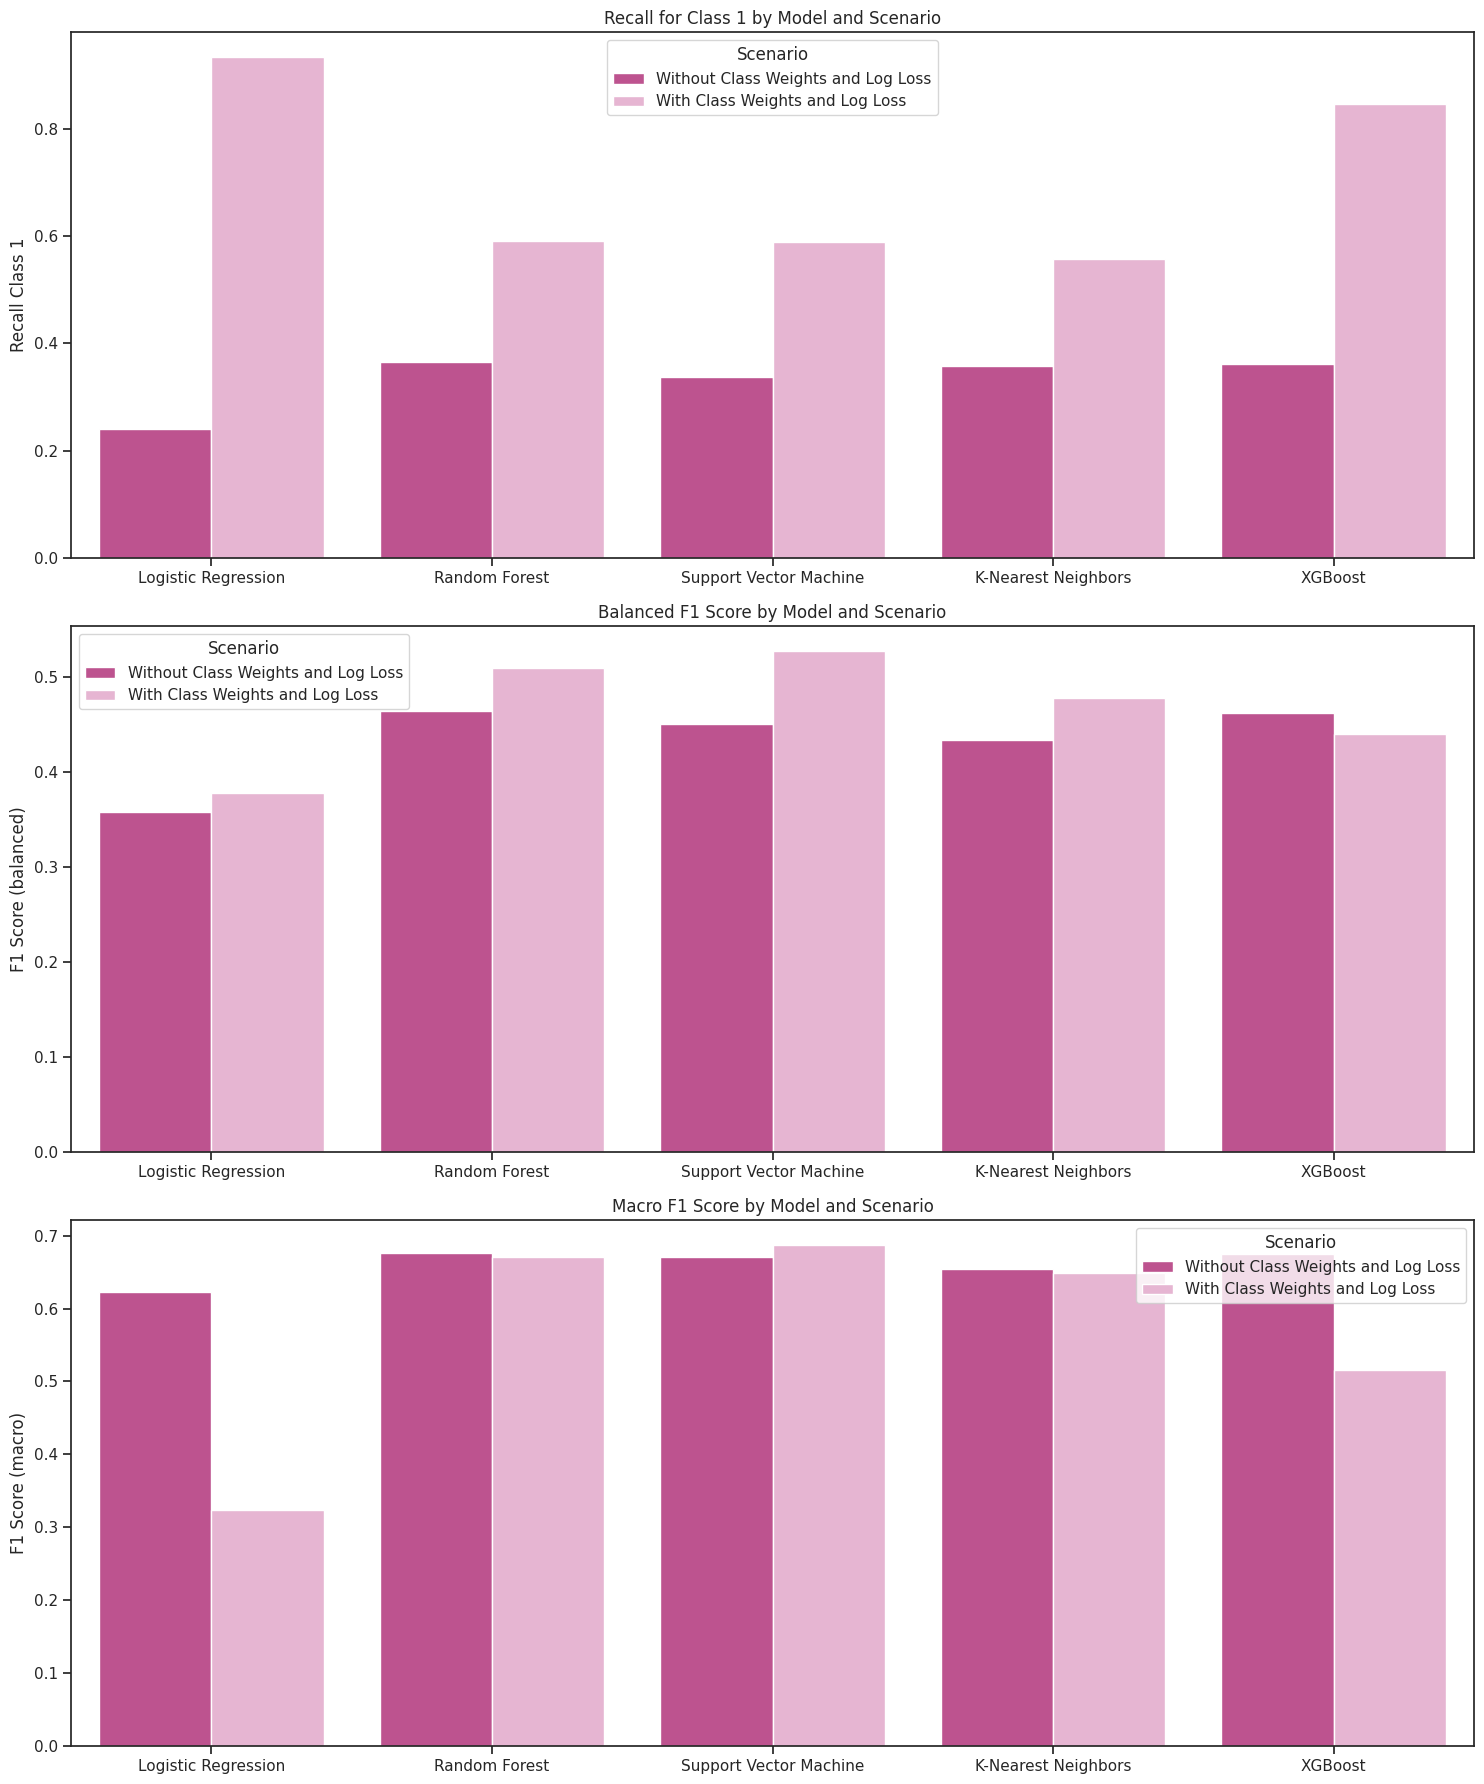

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine results for analysis
combined_results = []

# Add results without class weights and log loss
for name, metrics in results_without_weights.items():
    combined_results.append({
        'Model': name,
        'Scenario': 'Without Class Weights and Log Loss',
        'Recall Class 1': metrics['Recall Class 1'],
        'F1 Score (balanced)': metrics['F1 Score (balanced)'],
        'F1 Score (macro)': metrics['F1 Score (macro)']
    })

# Add results with class weights and log loss
for name, metrics in results_with_weights.items():
    combined_results.append({
        'Model': name,
        'Scenario': 'With Class Weights and Log Loss',
        'Recall Class 1': metrics['Recall Class 1'],
        'F1 Score (balanced)': metrics['F1 Score (balanced)'],
        'F1 Score (macro)': metrics['F1 Score (macro)']
    })

# Convert to DataFrame for better visualization
combined_results_df = pd.DataFrame(combined_results)

# Set up the matplotlib figure
sns.set_context('notebook')
sns.set_style('ticks')
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
palette = sns.color_palette('PiYG')

# Plot Recall for Class 1
sns.barplot(x='Model', y='Recall Class 1', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[0])
axes[0].set_title('Recall for Class 1 by Model and Scenario')
axes[0].set_ylabel('Recall Class 1')
axes[0].set_xlabel('')
axes[0].legend(title='Scenario')

# Plot F1 Score (balanced)
sns.barplot(x='Model', y='F1 Score (balanced)', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[1])
axes[1].set_title('Balanced F1 Score by Model and Scenario')
axes[1].set_ylabel('F1 Score (balanced)')
axes[1].set_xlabel('')
axes[1].legend(title='Scenario')

# Plot F1 Score (macro)
sns.barplot(x='Model', y='F1 Score (macro)', hue='Scenario', palette=palette, data=combined_results_df, ax=axes[2])
axes[2].set_title('Macro F1 Score by Model and Scenario')
axes[2].set_ylabel('F1 Score (macro)')
axes[2].set_xlabel('')
axes[2].legend(title='Scenario')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


In [25]:
# Display the combined results
combined_results_df

,Model,Scenario,Recall Class 1,F1 Score (balanced),F1 Score (macro)
0,Logistic Regression,Without Class Weights and Log Loss,0.239909,0.357143,0.623179
1,Random Forest,Without Class Weights and Log Loss,0.365575,0.463768,0.675993
2,Support Vector Machine,Without Class Weights and Log Loss,0.336634,0.450331,0.671414
3,K-Nearest Neighbors,Without Class Weights and Log Loss,0.358720,0.433303,0.653961
4,XGBoost,Without Class Weights and Log Loss,0.362529,0.462136,0.675334
5,Logistic Regression,With Class Weights and Log Loss,0.933740,0.378162,0.323599
6,Random Forest,With Class Weights and Log Loss,0.591775,0.509174,0.670881
7,Support Vector Machine,With Class Weights and Log Loss,0.588728,0.526746,0.686760
8,K-Nearest Neighbors,With Class Weights and Log Loss,0.558264,0.477214,0.648665
9,XGBoost,With Class Weights and Log Loss,0.846915,0.439613,0.515585


Sure, let's analyze the results:

### Recall for Class 1 (Loan Defaults)
- **Without Class Weights and Log Loss**:
  - Logistic Regression: 0.239909
  - Random Forest: 0.365575
  - Support Vector Machine: 0.336634
  - K-Nearest Neighbors: 0.358720
  - XGBoost: 0.362529

- **With Class Weights and Log Loss**:
  - Logistic Regression: 0.933740
  - Random Forest: 0.591775
  - Support Vector Machine: 0.588728
  - K-Nearest Neighbors: 0.558264
  - XGBoost: 0.846915

**Analysis**:
- The use of class weights and log loss significantly increased recall for class 1 across all models. Logistic Regression showed the most substantial improvement, achieving a recall of 0.933740 compared to 0.239909 without class weights and log loss.
- XGBoost also showed a notable increase in recall from 0.362529 to 0.846915.

### Balanced F1 Score
- **Without Class Weights and Log Loss**:
  - Logistic Regression: 0.357143
  - Random Forest: 0.463768
  - Support Vector Machine: 0.450331
  - K-Nearest Neighbors: 0.433303
  - XGBoost: 0.462136

- **With Class Weights and Log Loss**:
  - Logistic Regression: 0.378162
  - Random Forest: 0.509174
  - Support Vector Machine: 0.526746
  - K-Nearest Neighbors: 0.477214
  - XGBoost: 0.439613

**Analysis**:
- The balanced F1 score generally improved for most models with the use of class weights and log loss. The Support Vector Machine showed the highest balanced F1 score of 0.526746 when using class weights and log loss.
- Logistic Regression had a modest improvement in balanced F1 score, while XGBoost saw a slight decrease.

### Macro F1 Score
- **Without Class Weights and Log Loss**:
  - Logistic Regression: 0.623179
  - Random Forest: 0.675993
  - Support Vector Machine: 0.671414
  - K-Nearest Neighbors: 0.653961
  - XGBoost: 0.675334

- **With Class Weights and Log Loss**:
  - Logistic Regression: 0.323599
  - Random Forest: 0.670881
  - Support Vector Machine: 0.686760
  - K-Nearest Neighbors: 0.648665
  - XGBoost: 0.515585

**Analysis**:
- The macro F1 score decreased for Logistic Regression and XGBoost when using class weights and log loss. This indicates that while recall for class 1 improved significantly, the overall balance between precision and recall for both classes was affected.
- The Support Vector Machine showed an improvement in macro F1 score, indicating a better balance between precision and recall across classes with the use of class weights and log loss.

### Summary
- **Recall for Class 1**: The addition of class weights and log loss significantly improved recall for class 1 across all models, especially for Logistic Regression and XGBoost.
- **Balanced F1 Score**: Most models showed an improvement in balanced F1 score with the use of class weights and log loss, with the Support Vector Machine achieving the highest score.
- **Macro F1 Score**: The impact on macro F1 score was mixed, with Logistic Regression and XGBoost showing decreases, while the Support Vector Machine showed an improvement.

**Conclusion**:
Using class weights and log loss can significantly improve recall for the minority class (loan defaults), but it may also affect the balance of precision and recall across classes. It's important to consider these trade-offs when choosing the best model and configuration for your specific use case. The Support Vector Machine, in particular, showed good performance in both recall and balanced F1 score, making it a strong candidate for identifying loan defaults.

### Write Loan Data Utils Script

In [2]:
script_content=r'''
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None



'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
